**Author**: Andy Tzanidakis and the LINCC team \
Last updated: May 17, 2024

## Overview



- Learn how to use VizieR TAP query to access tables and store/handle them in `LSDB`
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Pass HipsCat LSDB catalogs to `TAPE` to perform time-series analysis and exploration


In [2]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
import tape
from tape import Ensemble, ColumnMapper
from cesium import featurize

## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
print(f'Version of TAPE is {tape.__version__}')

Version of lsdb is 0.2.4.dev11+gbe3e2fd
Version of TAPE is 0.4.1


## VizieR Querying

We will now access data from VizieR via the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service. We will be working with the `Gaia DR3 Golden Catalog`, a homogeneous sample of stars with high-quality stellar astrophysical parameters by exploiting data from the Gaia DR3 catalog. 
1. Visit the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service
2. Search "Gaia DR3"
2. Copy catalog ID number

In [8]:
CATALOGUE = "I/360" # from VizieR

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

In [9]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [10]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


Let's learn more about the particular catalog we have selected.

In [11]:
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Subjects: I/360
Waveband Coverage: optical
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [12]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [13]:
# Initialize tap service
tap_service = voresource.get_service("tap")
# Run a query to get the first 2000000 rows given a sky constraint (40x40 deg)
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')

Fetch the data and covert it to a pandas DataFrame.

In [14]:
# Obtain table from TAP query
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [16]:
print (f"Number of objects: {len(table_df)}")

Number of objects: 146151


Text(0, 0.5, 'DEC [deg]')

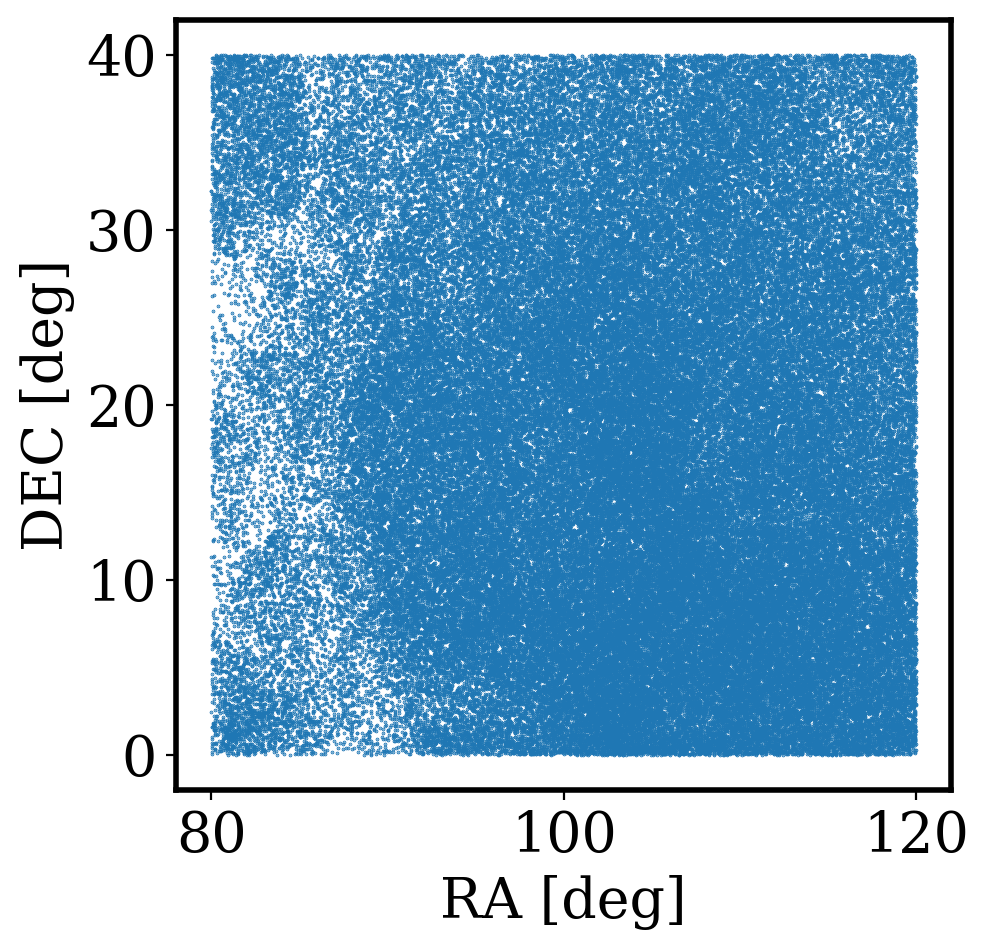

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.1)

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [18]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [19]:
# remove the Spectral Type column from the original table since we have only selected M-dwarfs
table_df = table_df.drop(columns=['SpType'], axis=1)

In [20]:
print (f"Number of M-type stars: {len(table_df)}")

Number of M-type stars: 1304


Inspect the table.

In [23]:
table_df.head(2)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
96,1302564,3414418568469105024,3537.0732,4.8277,-0.4692,1.0736,0.6528,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.069883,21.728261,80.069883,21.728261
97,404378,184080241020594432,3480.0610,4.9449,-0.4401,0.5360,0.3295,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.070542,36.902685,80.070542,36.902685


In [24]:
table_df.columns

Index(['recno', 'Source', 'Teff-P', 'logg-P', '[M/H]-P', 'AG-P', 'E(BP-RP)-P',
       '[alphe/Fe]-S', 'Teff-S', 'logg-S', '[M/H]-S', 'Rad-F', 'Lum-F',
       'Mass-F', 'Age-F', 'evol-F', 'Rad-FS', 'Lum-FS', 'Mass-FS', 'Age-FS',
       'evol-FS', 'RA_ICRS', 'DE_ICRS', '_RA_icrs', '_DE_icrs'],
      dtype='object')

From above we can see that the original table contains many columns. We will select only a few handful columns to reduce the object table size.

In [25]:
# Select only a few columns
table_df = table_df[['Teff-P', 'RA_ICRS', 'DE_ICRS', 'logg-P', 'Lum-F']]

In [26]:
table_df.head(1)

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F
96,3537.0732,80.069883,21.728261,4.8277,0.018851


Make an HR diagram visualization.

Text(0, 0.5, '$\\log L/L_{\\odot}$')

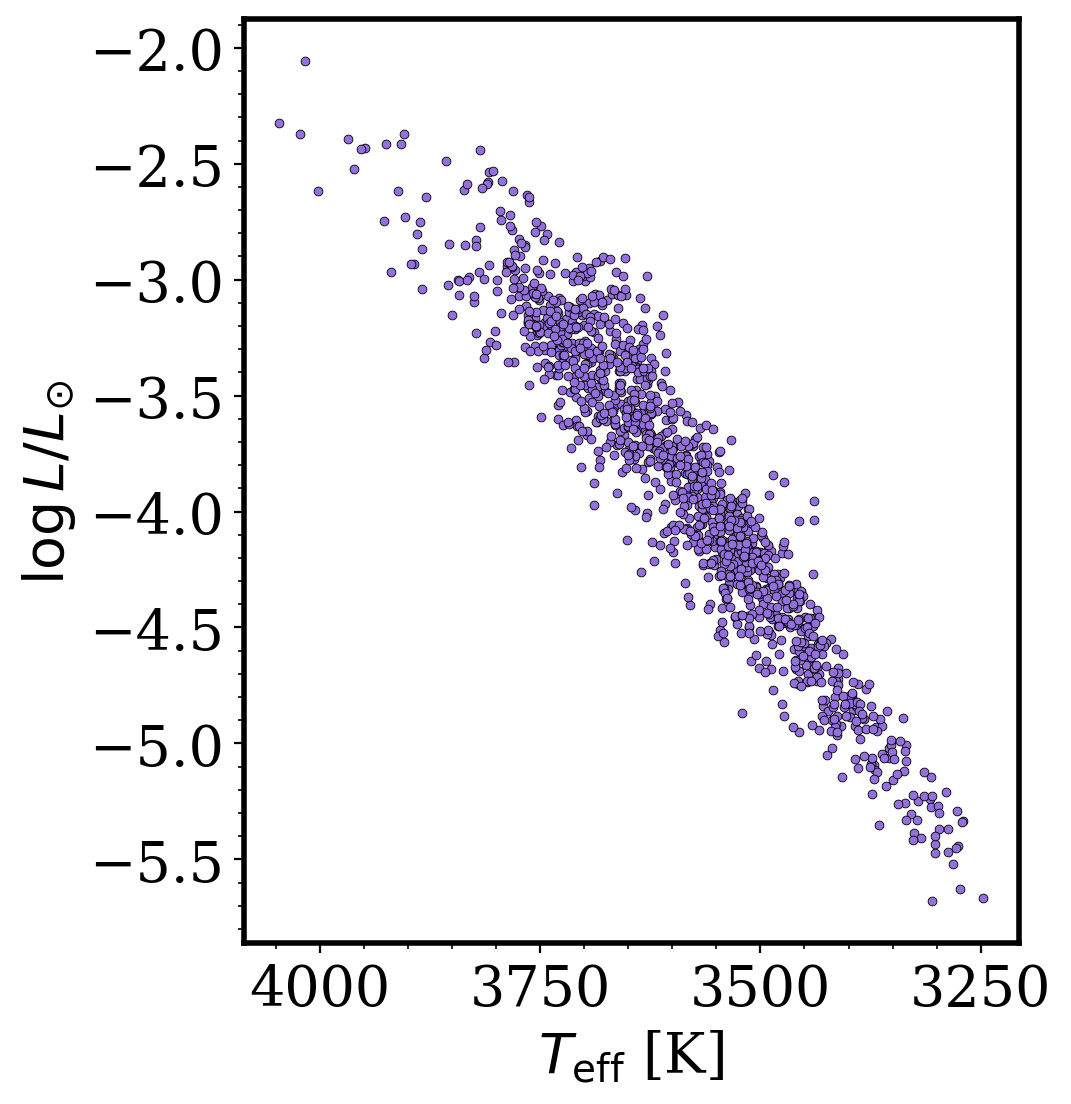

In [42]:
plt.figure(figsize=(5, 6))
plt.scatter((table_df['Teff-P']), np.log(table_df['Lum-F']), s=10, color='mediumpurple', edgecolor='k', lw=0.3)
plt.xlim(plt.xlim()[::-1])
plt.minorticks_on()
plt.xlabel(r'$T_{\rm eff}$ [K]')
plt.ylabel(r'$\log L/L_{\odot}$')

## Initialize Dask Client
Initialize dask client with 2 workers.We initialize with 12 GiB of memory and 1 thread per worker, so that we sure we do not overload the memory resources of the machine.

In [27]:
# initialize dask client
client = Client(n_workers=2, threads_per_worker=1, memory_limit='12GiB')

## Initialize hipscat catalogs

In [45]:
%%time

# URL to the directory containing the Hipscat catalogs
catalogs_dir = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys"

gaia = lsdb.read_hipscat(f"{catalogs_dir}/gaia_dr3/gaia", columns=['ra', 'dec', 'parallax'],
 search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# load ZTF object table
ztf = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_dr14", columns=['ra', 'dec', 'ps1_objid'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_zource", columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

CPU times: user 1.7 s, sys: 366 ms, total: 2.06 s
Wall time: 2.01 s


Now we will hipscat the Gaia DR3 golden table.

In [46]:
%%time
# Hipsccat VizieR table
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS"
    )

CPU times: user 24.9 s, sys: 1.05 s, total: 25.9 s
Wall time: 26.3 s


In [47]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=3,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1152921504606846976,...,...,...,...,...,...,...,...
5764607523034234880,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


Visualize the catalog pixel density map of our hipcat table.

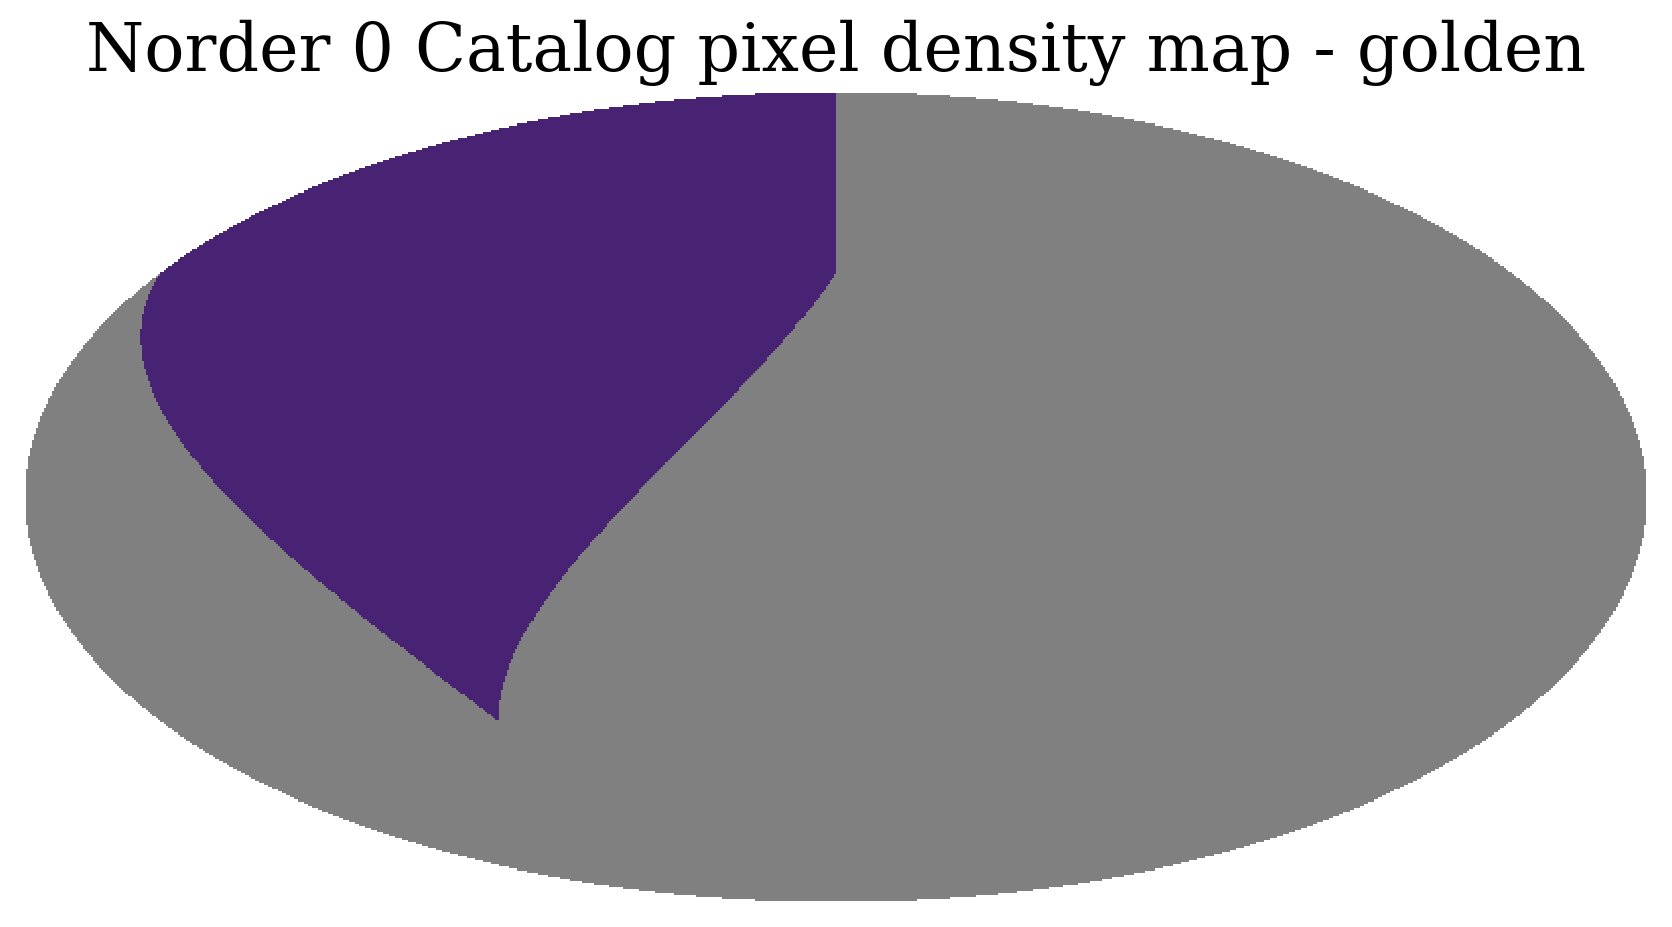

In [22]:
from hipscat.inspection import plot_pixels
plot_pixels(hips_object.hc_structure)

In [48]:
%%time
hips_object.head(1)

CPU times: user 94.5 ms, sys: 14.2 ms, total: 109 ms
Wall time: 158 ms


,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
_hipscat_index,,,,,,,,
368160526343077888,3480.061,80.070542,36.902685,4.9449,0.014007,0,0,0


## Crossmatch

We will now crossmatch our hipscat table to the ZTF object table.

In [25]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=3,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1152921504606846976,...,...,...,...,...,...,...,...
5764607523034234880,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [49]:
# Crossmatch the gaia golden table object with Gaia
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, 
                                                  n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


Compute the crossmatch table.

In [52]:
%%time 

# Compute the crossmatched hipscatted table
xmatch_comp = xmatch_golden_ztf_object.compute()

In [53]:
xmatch_comp.head(5)

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,
1767831764316717056,3534.9400,105.236489,26.617695,4.8304,0.019377,0,0,1,105.236494,26.617702,139941052365021827,0.029991
1768150062128431104,3587.2402,105.745689,27.471973,4.8918,0.016971,0,0,1,105.745723,27.471958,140961057456367022,0.121005
1767761412286840832,3542.0710,105.920583,26.607892,4.9428,0.013047,0,0,1,105.920670,26.607914,139931059204300037,0.287630
1769648820116783104,3523.6733,106.829414,28.876755,4.8220,0.017512,0,0,1,106.829478,28.876686,142651068293082899,0.321395
1765463920757178368,3480.4011,106.894531,24.971470,4.8832,0.013477,0,0,1,106.894505,24.971481,137961068945876343,0.093585


Join the `xmatch_comp` table to the ZTF source catalog using the Pan-STARSS1 ID's.

In [70]:
%%time
# sync source catalog data to object (xmatched) object
_sources = xmatch_comp.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

TypeError: DataFrame.join() got an unexpected keyword argument 'left_on'

In [34]:
ztf_sources

,ra,dec,mjd,mag,magerr,band,ps1_objid,catflags
npartitions=84,,,,,,,,
1768225803696340992,double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
1774418253183975424,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
6871930081413955584,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [35]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=25,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## TAPE (Timeseries Analysis & Processing Engine)

The TAPE `ensemble` specializes performing time-domain work on object/source data. Like `LSDB`, it's built on top of Dask. In the following cell, we initialize an `Ensemble` object and pass it the dask client to run computations on.

In [36]:
# Initialize an Ensemble
ens = Ensemble(client=client)

client # display client information

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:54311/status,
Dashboard: http://127.0.0.1:54311/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54312,Workers: 2
Dashboard: http://127.0.0.1:54311/status,Total threads: 2
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:54320,Total threads: 1
Dashboard: http://127.0.0.1:54321/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:54315,


In [37]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=25,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Loading data into TAPE has two steps, the first is to establish a `ColumnMapper` which maps columns from the table to known timeseries quantities. These columns are used implicitly in some TAPE functionality. The second step is to call a loader function to get data into LSDB. In this case, we can load directly from LSDB catalogs, using the `from_lsdb` function. We provide a source catalog and an object catalog as well as the `ColumnMapper`.

In [38]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_zource',
        flux_col='mag_ztf_zource',
        err_col='magerr_ztf_zource',
        band_col='band_ztf_zource',
      )

ens.from_lsdb(
    source_catalog=_sources,
    object_catalog=hips_object_v2,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

Within the Ensemble, we're able to access our Object and Source tables.

In [39]:
print(f'Number of columns: {len(ens.source.columns)}')
ens.source

Number of columns: 22


,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=25,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can also use the `to_timeseries` function to select a single object by ID.

In [40]:
# TODO: maybe choose a particular object to show the timeseries for
ts = ens.to_timeseries(6759861235694436352)

ts.data  # the data property holds a Pandas dataframe of the information

Teff-P_golden_golden_x_ztf_dr14  RA_ICRS_golden_golden_x_ztf_dr14  \
band index                                                                      
r    0                            3739.6497                        101.372429   
     1                            3739.6497                        101.372429   
     2                            3739.6497                        101.372429   
     3                            3739.6497                        101.372429   
     4                            3739.6497                        101.372429   
...                                     ...                               ...   
     841                          3739.6497                        101.372429   
     842                          3739.6497                        101.372429   
     843                          3739.6497                        101.372429   
     844                          3739.6497                        101.372429   
     845                          3739.6497                        101.372429   

            DE_ICRS_golden_golden_x_ztf_dr14  logg-P_golden_golden_x_ztf_dr14  \
band index                                                                      
r    0                             24.326345                           4.8254   
     1                             24.326345                           4.8254   
     2                             24.326345                           4.8254   
     3                             24.326345                           4.8254   
     4                             24.326345                           4.8254   
...                                      ...                              ...   
     841                           24.326345                           4.8254   
     842                           24.326345                           4.8254   
     843                           24.326345                           4.8254   
     844                           24.326345                           4.8254   
     845                           24.326345                           4.8254   

            Lum-F_golden_golden_x_ztf_dr14  Norder_golden_golden_x_ztf_dr14  \
band index                                                                    
r    0                            0.033149                                0   
     1                            0.033149                                0   
     2                            0.033149                                0   
     3                            0.033149                                0   
     4                            0.033149                                0   
...                                    ...                              ...   
     841                          0.033149                                0   
     842                          0.033149                                0   
     843                          0.033149                                0   
     844                          0.033149                                0   
     845                          0.033149                                0   

            Dir_golden_golden_x_ztf_dr14  Npix_golden_golden_x_ztf_dr14  \
band index                                                                
r    0                                 0                              5   
     1                                 0                              5   
     2                                 0                              5   
     3                                 0                              5   
     4                                 0                              5   
...                                  ...                            ...   
     841                               0                              5   
     842                               0                              5   
     843                               0                              5   
     844                               0           

(16.621712122205643, 15.614585388358682)

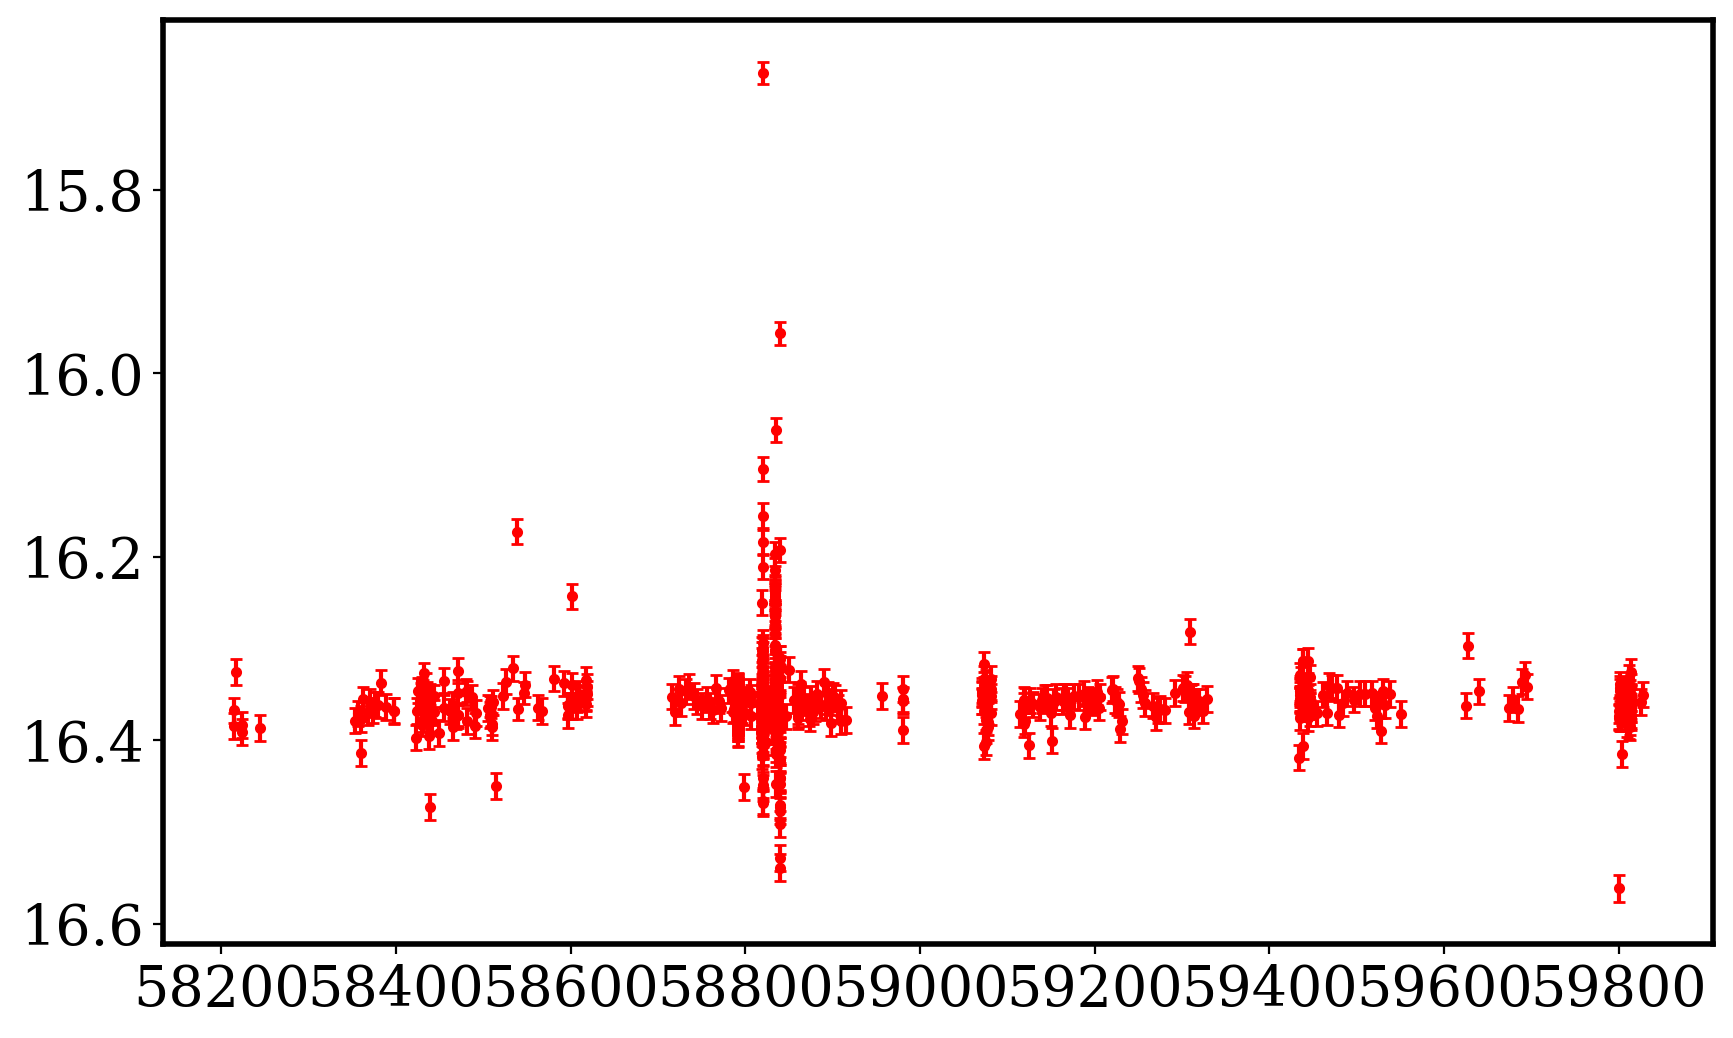

In [41]:
rband = ts.data[ts.band=='r']

plt.figure(figsize=(10, 6))
plt.errorbar(rband.mjd_ztf_zource, rband.mag_ztf_zource, yerr=rband.magerr_ztf_zource, color='r', fmt='.', capsize=2)
plt.ylim(plt.ylim()[::-1])



## Calculating Time-Series Features

TAPE allows you to write custom analysis functions that can be passed along to each timeseries in your dataset. We'll define a custom feature calculation function.

In [42]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [43]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    # Compute features
    summary_ = {}

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 


Often, you'll need the specify the "meta" of the output, as a consequence of these operations being lazy. This is an empty dataframe that "looks" like the output of the `batch` applied function. In this case, we specify an empty dataframe with a column per feature output, and specify that every column will be a float output.

In [44]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

In [45]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=25,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We then use `batch` to apply our `compute_features` function to each lightcurve in the dataset.

In [46]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 7.14 ms, sys: 23 µs, total: 7.16 ms
Wall time: 2.19 ms


In [47]:
%%time
# around 4 minutes
new_table = calc_.compute()

CPU times: user 10.9 s, sys: 2.62 s, total: 13.5 s
Wall time: 5min 55s


In [48]:
new_table

,amplitude,percent_beyond_1_std,maximum,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,stetson_j,stetson_k
_hipscat_index,,,,,,,,,,,,,,,,,
6759861235694436352,0.052757,0.274924,16.418705,16.361895,0.008821,0.589124,16.313190,0.048448,0.014154,16.361353,0.146970,0.269720,0.397893,0.551996,0.743753,-0.989740,0.962813
6762483210258481152,0.060066,0.255814,17.033401,16.985670,0.012396,0.488372,16.913269,-0.597125,0.022151,16.982361,0.140068,0.214612,0.356626,0.473270,0.693780,-0.973225,0.944264
6762597460679327744,0.111551,0.295638,17.396904,17.321072,0.015787,0.662359,17.173801,-0.468346,0.024618,17.319266,0.170836,0.289530,0.416222,0.558207,0.786740,-0.966274,0.975627
6763056230786138112,0.088201,0.273621,16.215702,16.119698,0.010773,0.727135,16.039301,0.050355,0.017467,16.119739,0.144471,0.260029,0.378466,0.523540,0.733181,-0.984028,0.960818
6763105036554731520,0.047082,0.317460,14.725718,14.667343,0.008973,0.534392,14.631554,0.476860,0.012829,14.668046,0.167918,0.290467,0.446868,0.616877,0.765362,-0.991552,0.980090
6763786659667378176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6763563429186764800,0.065872,0.304598,16.734638,16.667658,0.012453,0.514368,16.602894,0.107560,0.018547,16.668498,0.150180,0.268961,0.420216,0.572699,0.769507,-0.982200,0.987091
6764043431367933952,0.054981,0.252747,15.668400,15.629448,0.011406,0.494505,15.558437,-0.362726,0.019008,15.627881,0.155377,0.244235,0.344195,0.498578,0.661446,-0.980893,0.963381
6763859177497427968,0.070125,0.279710,16.589800,16.511481,0.012045,0.563768,16.449551,0.047531,0.018359,16.511944,0.139847,0.256841,0.402043,0.544798,0.729620,-0.982505,0.974077


In [49]:
client.shutdown()